## Double Machine Learning (DML) CATE Estimators

In [1]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os 
import urllib.request
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display

# Generic ML imports
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# DoWhy imports 
import dowhy
from dowhy import CausalModel

# EconML imports
from econml.dml import LinearDML, CausalForestDML, DML
from econml.iv.dr import LinearIntentToTreatDRIV

from econml.inference import BootstrapInference
from econml.cate_interpreter import SingleTreeCateInterpreter, \
                                    SingleTreePolicyInterpreter

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Custom DoWhy helper functions
from pathlib import Path
import os
import sys
cwd = Path().resolve()
PARENT_DIR = os.path.dirname(cwd)
SCRIPT_DIR = os.path.join(PARENT_DIR, 'helpers')
sys.path.append(SCRIPT_DIR)
import dowhy_helpers as dwh

In [2]:
# I/O Stuff
DATA_FILENAME = "csdh_clean.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME
csdh = pd.read_csv(DATA_FILEPATH)

---
## 0. Naïve ATE Estimation (no causal inference)

In [3]:
naive_est = dwh.naive_estimate(df=csdh, treatment='drain', outcome='recurrence', treatment_type='int')
print(f"Without adjusting for any confounding, the naive causal estimate is computed as {naive_est}")

Without adjusting for any confounding, the naive causal estimate is computed as -0.09356128931064231


---

In [155]:
Z = csdh['hospital'].values
T = csdh['drain'].values
Y = csdh['recurrence'].values
X = csdh[['antiplatelet', 'thickness_sum', 'stroke', 'ihd', 'metalvalve', 'age']].values

confounder_names = ['platelet', 'hospital', 'inr']
W = csdh[confounder_names].values

In [195]:
# initiate an EconML cate estimator
est = LinearDML(model_y=GradientBoostingClassifier(), 
          model_t=GradientBoostingClassifier(),
                random_state=42,
                fit_cate_intercept=False,
          featurizer=PolynomialFeatures(degree=1, include_bias=False),
          discrete_treatment=True,
                categories=[0,1]
         )

In [196]:
# fit through dowhy
est_dw = est.dowhy.fit(Y, T, Z=Z, X=X, W=W, outcome_names=["recurrence"], treatment_names=["drain"], feature_names=['antiplatelet', 'thickness_sum', 'stroke', 'ihd', 'metalvalve', 'age'],
                       graph='../causal_graphs/cate_dag.dot'.replace("\n", " "),
               confounder_names=confounder_names, inference="statsmodels")

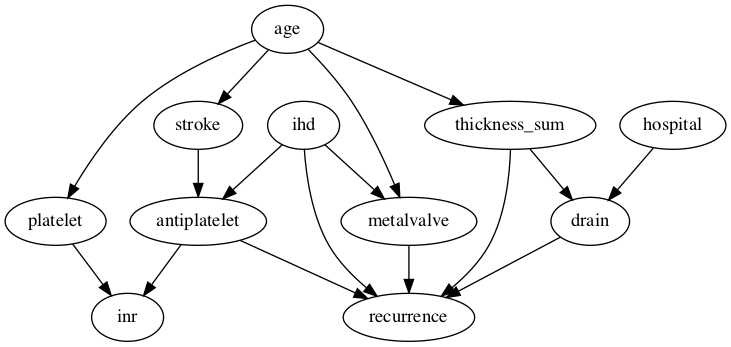

In [197]:
# Visualize causal graph
try:
    # Try pretty printing the graph. Requires pydot and pygraphviz
    display(
        Image(to_pydot(est_dw._graph._graph).create_png())
    )
except:
    # Fall back on default graph view
    est_dw.view_model()

In [198]:
identified_estimand = est_dw.identified_estimand_
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|thickness_sum,stroke,platelet,age,antiplatelet
d[drain]                                                                      

                 
,metalvalve,ihd))
                 
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,thickness_sum,stroke,platelet,age,antiplatelet,metalvalve,ihd,U) = P(recurrence|drain,thickness_sum,stroke,platelet,age,antiplatelet,metalvalve,ihd)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(recurrence, [hospital])*Derivative([drain], [hospital])
**(-1))
Estimand assumption 1, As-if-random: If U→→recurrence then ¬(U →→{hospital})
Estimand assumption 2, Exclusion: If we remove {hospital}→{drain}, then ¬({hospital}→recurrence)

### Estimand : 3
Estimand name: frontdoor
No such

In [199]:
forestdml_estimate = est_dw.estimate_
print(forestdml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|thickness_sum,stroke,platelet,age,antiplatelet
d[drain]                                                                      

                 
,metalvalve,ihd))
                 
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,thickness_sum,stroke,platelet,age,antiplatelet,metalvalve,ihd,U) = P(recurrence|drain,thickness_sum,stroke,platelet,age,antiplatelet,metalvalve,ihd)

## Realized estimand
b: recurrence~drain+thickness_sum+stroke+platelet+age+antiplatelet+metalvalve+ihd | antiplatelet,thickness_sum,stroke,ihd,metalvalve,age
Target units: ate

## Estimate
Mean value: -0.1202991035631895
Effect estimates: [-6.99775368e-02 -1.09328513e-02 -7.63835017e-02 -1.91141826e-02
 -2.43365699e-0

In [200]:
# Get the final coefficient and intercept summary
est_dw.summary(feature_names=['antiplatelet', 'thickness_sum', 'stroke', 'ihd', 'metalvalve', 'age'])

CATE Intercept Results:  No intercept was fitted!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
antiplatelet,-0.071,0.08,-0.896,0.37,-0.203,0.06
thickness_sum,-0.004,0.003,-1.544,0.123,-0.008,0.0
stroke,0.037,0.09,0.414,0.679,-0.11,0.184
ihd,-0.204,0.093,-2.191,0.028,-0.358,-0.051
metalvalve,0.158,0.091,1.744,0.081,0.009,0.307
age,0.001,0.001,0.608,0.543,-0.001,0.002


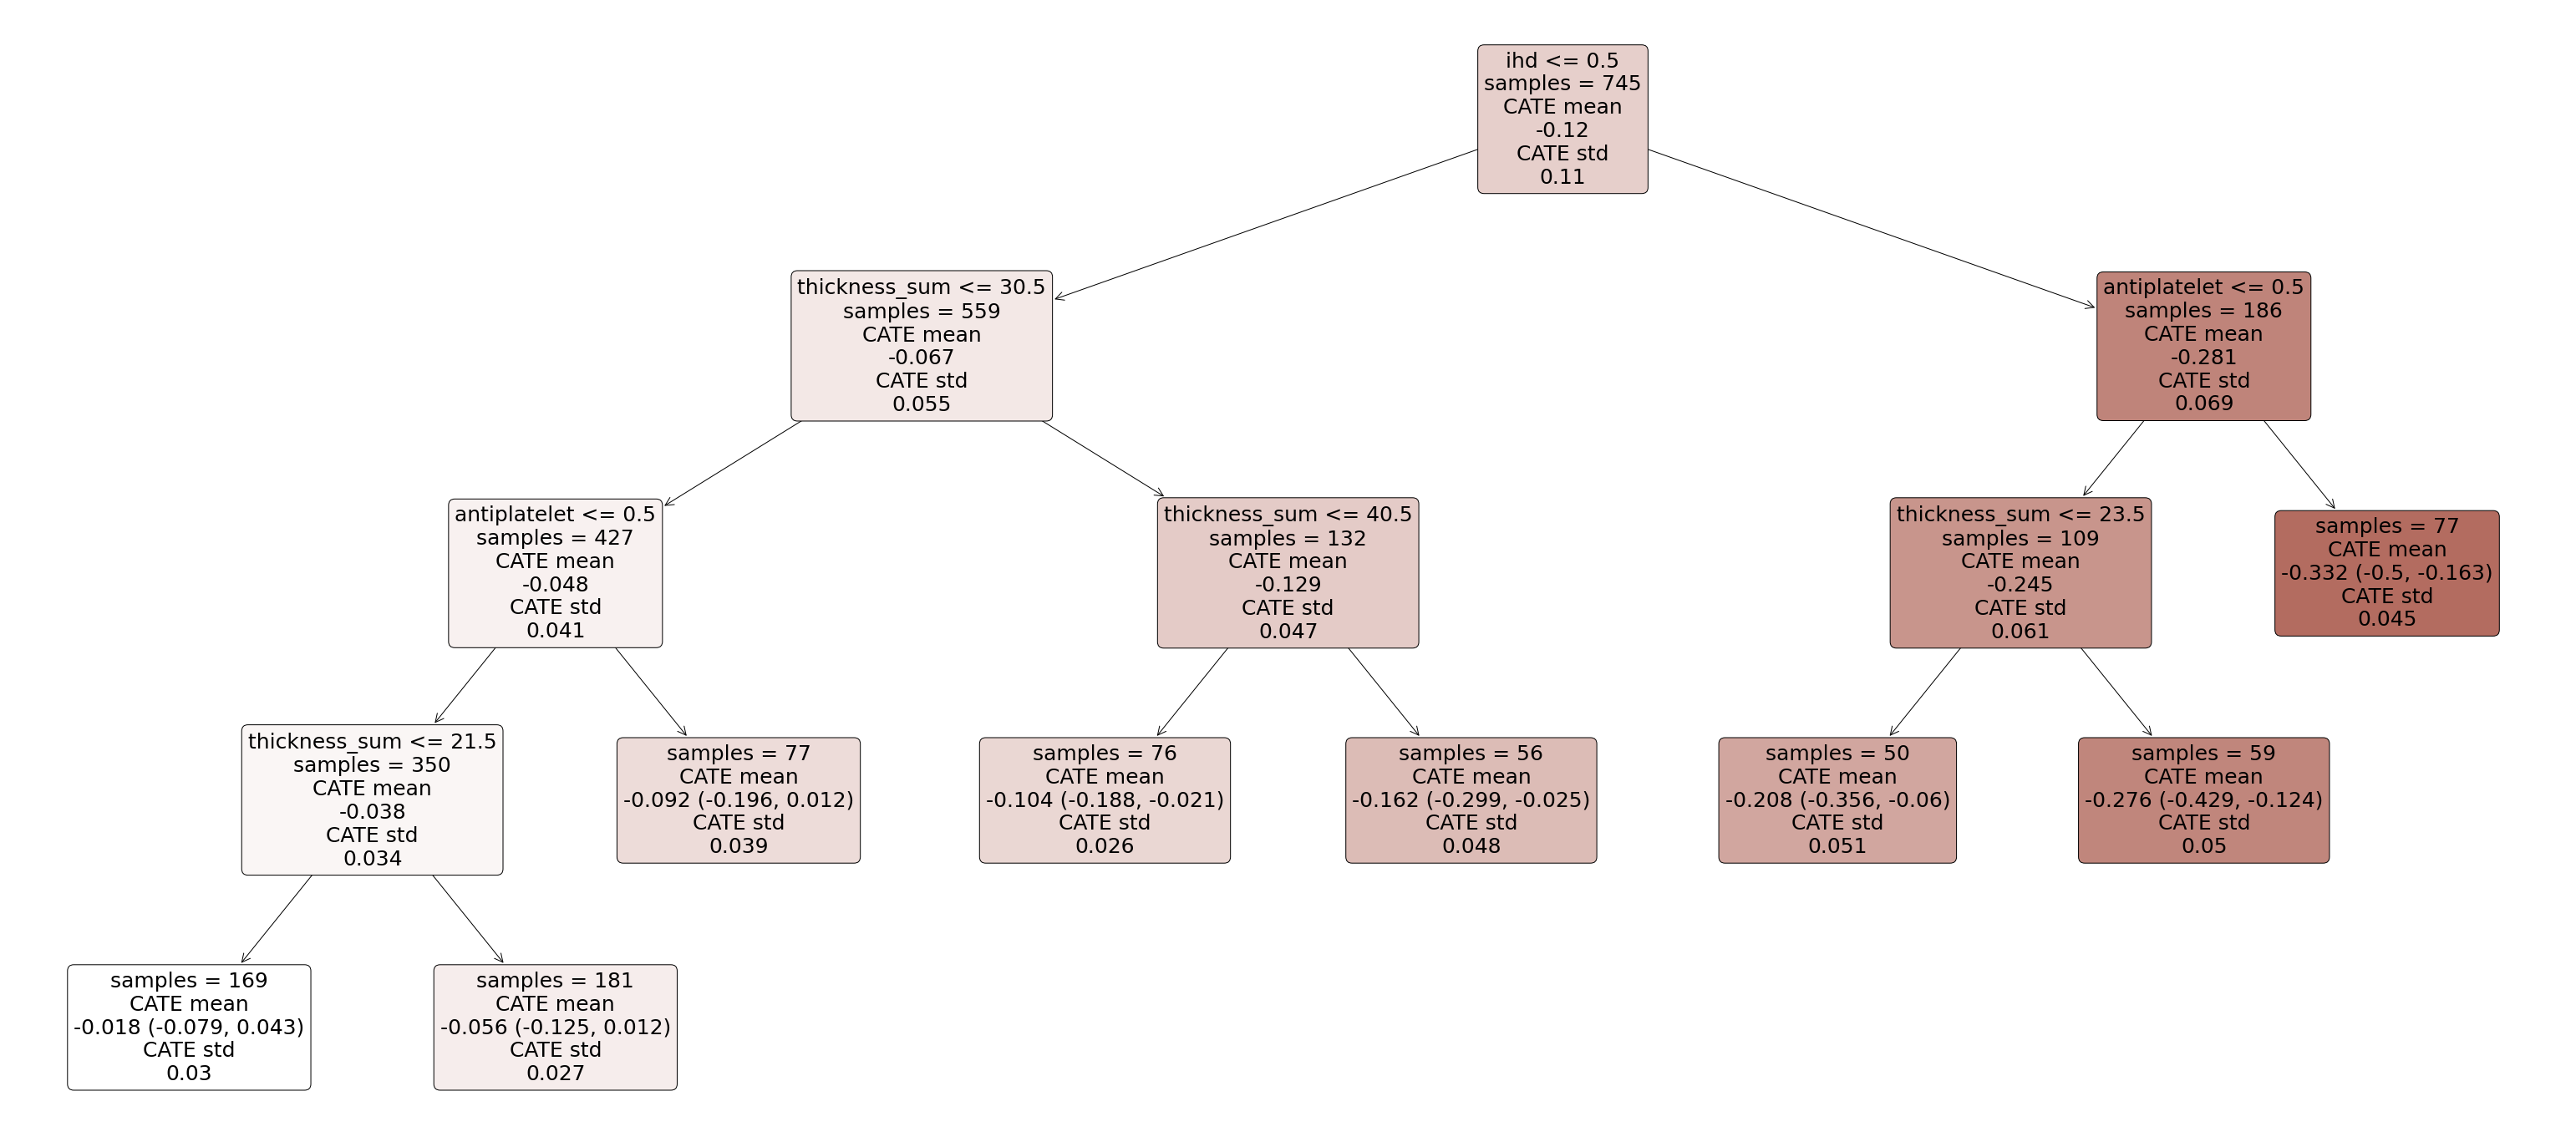

In [201]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=4, min_samples_leaf=50)
intrp.interpret(est_dw, X)
plt.figure(figsize=(55, 25))
intrp.plot(feature_names=['antiplatelet', 'thickness_sum', 'stroke', 'ihd', 'metalvalve', 'age'], fontsize=25)

---
# Treatment Investigation

In [122]:
csdh[csdh['burrhole_num'].isna()].index

Int64Index([  5,  17,  24,  29,  33,  37,  42,  57,  64,  65,
            ...
            690, 691, 696, 697, 703, 711, 720, 722, 724, 728],
           dtype='int64', length=151)

In [123]:
csdh_burr = csdh.drop(csdh[csdh['burrhole_num'].isna()].index)

In [124]:
# Mapping bedrest to categorical variable
csdh_burr['bedrest'] = csdh_burr['bedrest'].map({'None':0, '<12hrs':1, '12-24hrs':2, '25-48hrs':3, '>48hrs':4})

In [125]:
sum(csdh_burr['recurrence']==1)

In [126]:
sum(csdh_burr['recurrence']==0)

In [127]:
T = csdh_burr['drain'].values
Y = csdh_burr['recurrence'].values
X = csdh_burr[['burrhole_num', 'optype', 'bedrest']].values

confounder_names = ['platelet', 'hospital', 'antiplatelet', 'stroke', 'ihd',
                    'metalvalve', 'age', 'membranes', 'inr', 'thickness_sum']
W = csdh_burr[confounder_names].values

In [128]:
# initiate an EconML cate estimator
est = LinearDML(model_y=GradientBoostingClassifier(), 
          model_t=GradientBoostingClassifier(),
                random_state=1,
                fit_cate_intercept=False,
          featurizer=PolynomialFeatures(degree=1, include_bias=False),
          discrete_treatment=True,
                categories=[0,1]
         )

In [129]:
# fit through dowhy
est_dw = est.dowhy.fit(Y, T, X=X, W=W, outcome_names=["recurrence"], treatment_names=["drain"], feature_names=['burrhole_num', 'optype', 'bedrest'],
                       graph='../causal_graphs/treatment_dag.dot'.replace("\n", " "),
               confounder_names=confounder_names, inference="statsmodels")

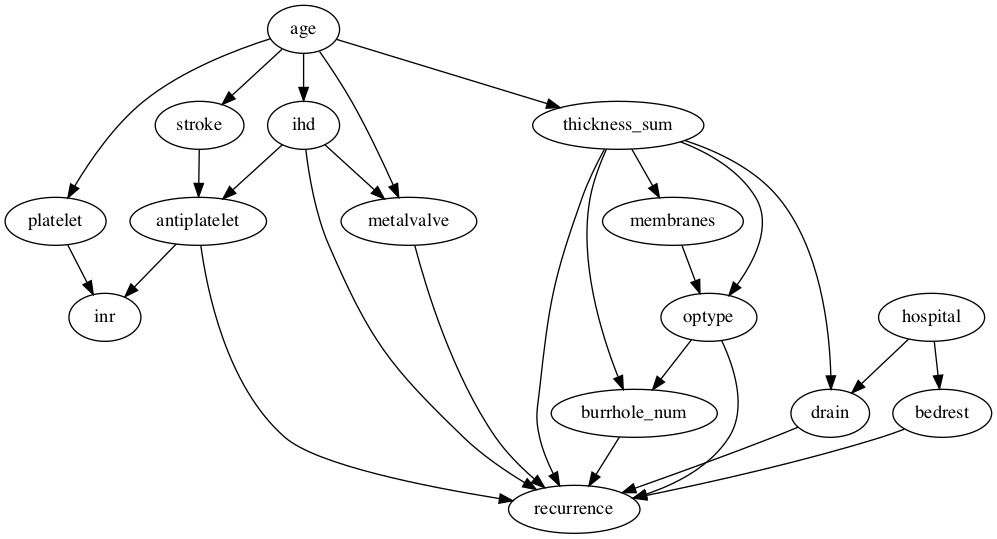

In [130]:
# Visualize causal graph
try:
    # Try pretty printing the graph. Requires pydot and pygraphviz
    display(
        Image(to_pydot(est_dw._graph._graph).create_png())
    )
except:
    # Fall back on default graph view
    est_dw.view_model()

In [131]:
identified_estimand = est_dw.identified_estimand_
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|platelet,membranes,inr,thickness_sum,bedrest,s
d[drain]                                                                      

                                                                    
troke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet))
                                                                    
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,platelet,membranes,inr,thickness_sum,bedrest,stroke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet,U) = P(recurrence|drain,platelet,membranes,inr,thickness_sum,bedrest,stroke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such va

In [132]:
forestdml_estimate = est_dw.estimate_
print(forestdml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|platelet,membranes,inr,thickness_sum,bedrest,s
d[drain]                                                                      

                                                                    
troke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet))
                                                                    
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,platelet,membranes,inr,thickness_sum,bedrest,stroke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet,U) = P(recurrence|drain,platelet,membranes,inr,thickness_sum,bedrest,stroke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet)

## Realized estimand
b: recurrence~drain+platelet+membranes+inr+

In [133]:
# Get the final coefficient and intercept summary
est_dw.summary(feature_names=['burrhole_num', 'optype', 'bedrest'])

CATE Intercept Results:  No intercept was fitted!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
burrhole_num,-0.015,0.043,-0.35,0.727,-0.086,0.056
optype,-0.083,0.068,-1.228,0.219,-0.194,0.028
bedrest,0.01,0.038,0.251,0.801,-0.053,0.072


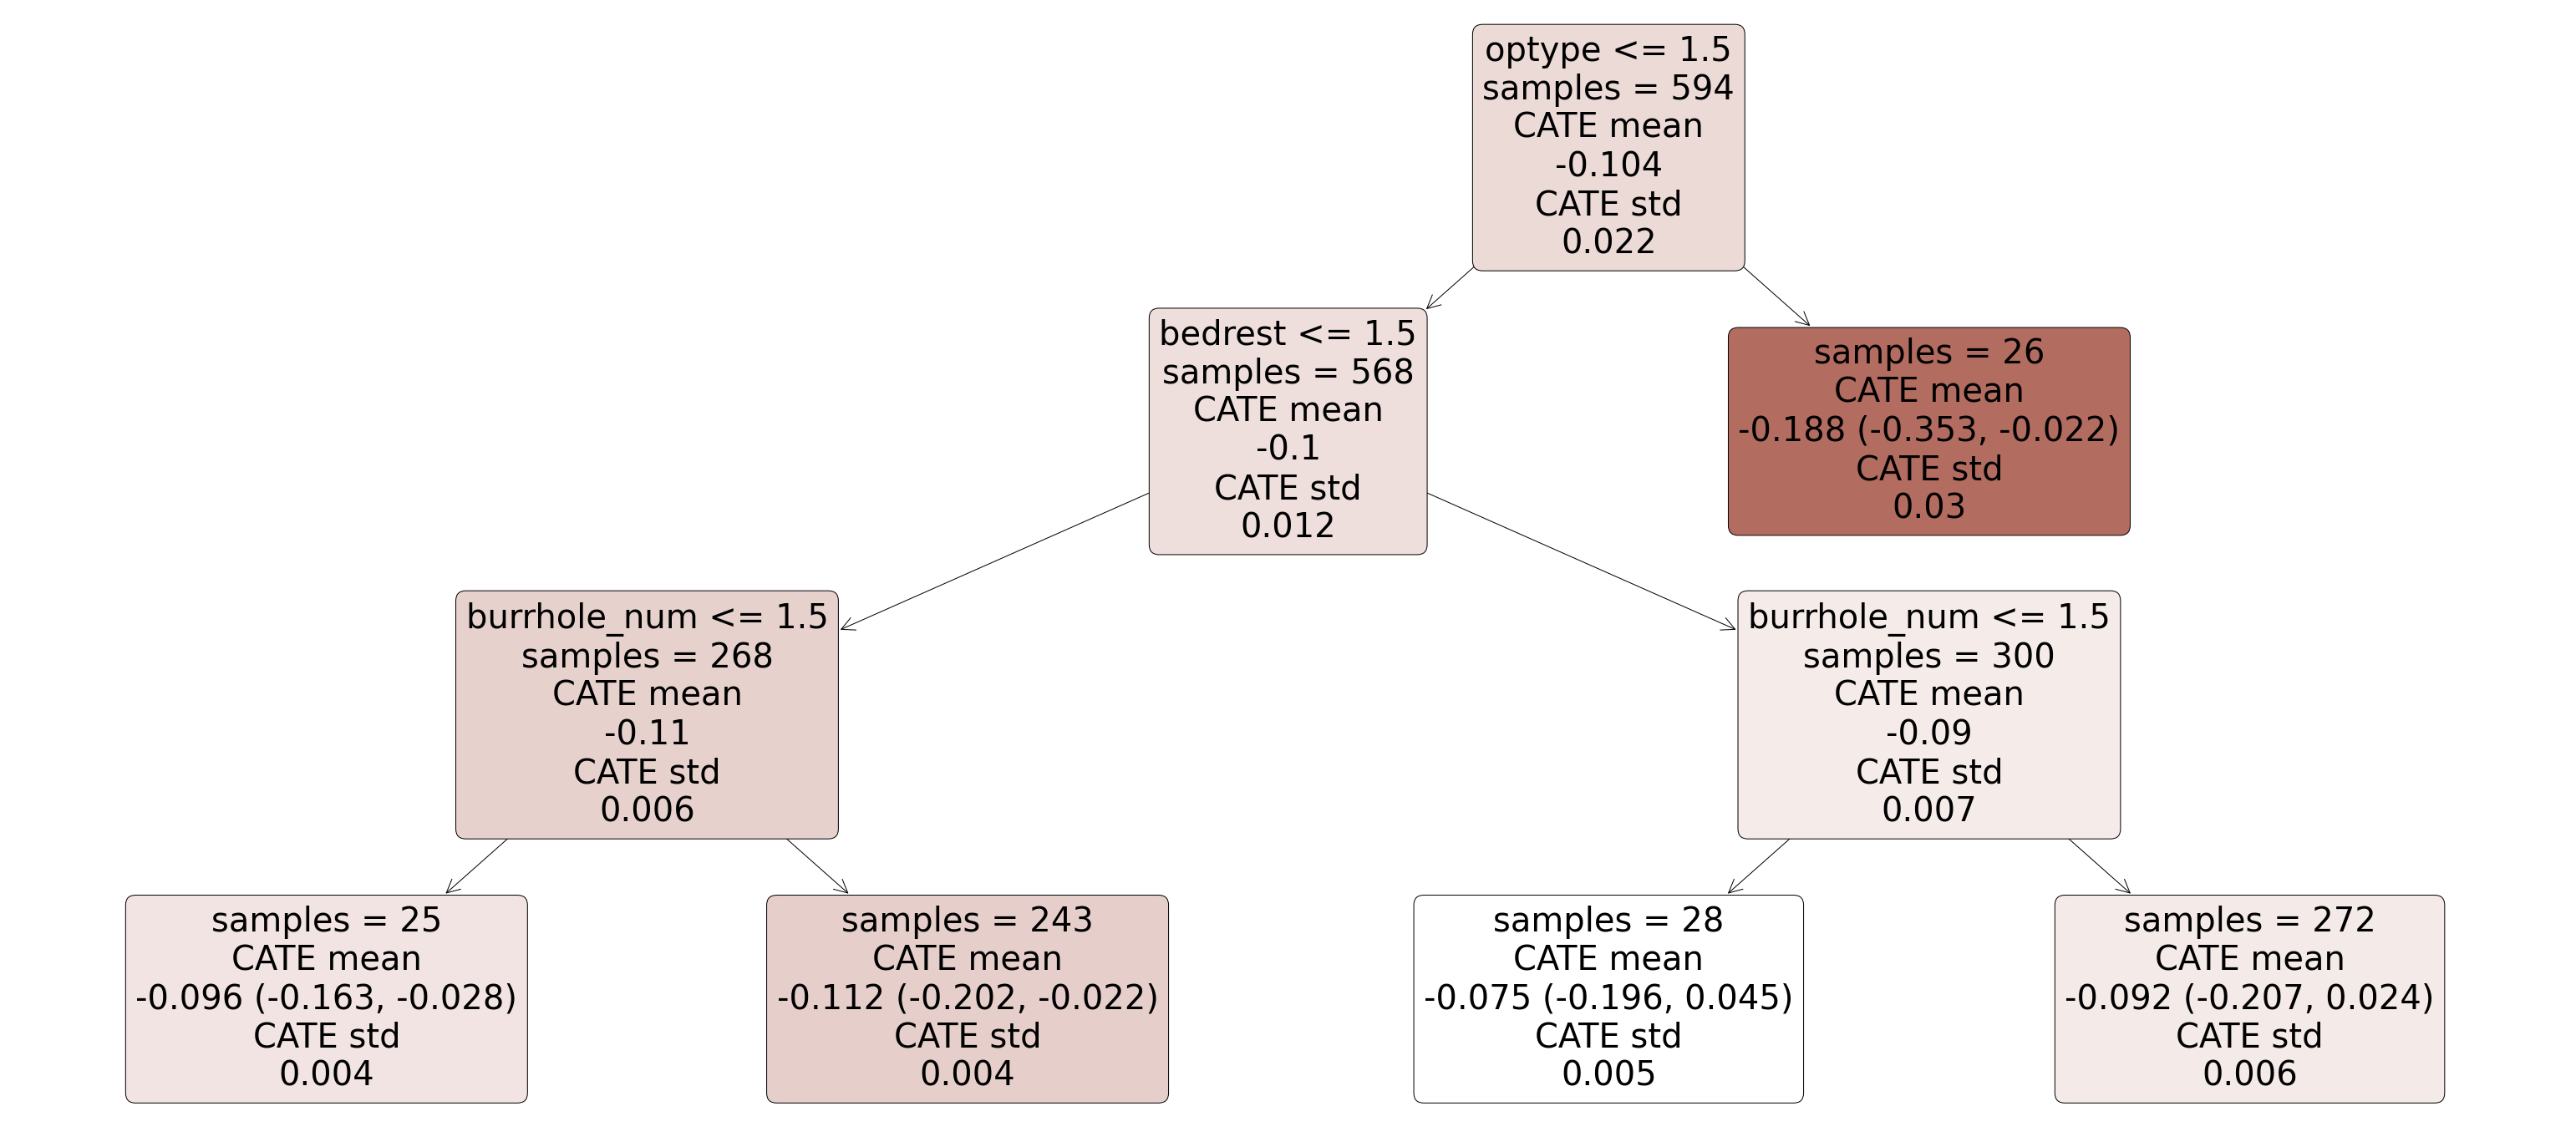

In [137]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=10)
intrp.interpret(est_dw, X)
plt.figure(figsize=(55, 25))
intrp.plot(feature_names=['burrhole_num', 'optype', 'bedrest'], fontsize=40)

In [223]:
T = csdh_burr['drain'].values
Y = csdh_burr['recurrence'].values
X = csdh_burr[['burrhole_num', 'optype', 'bedrest', 'antiplatelet', 'ihd', 'metalvalve', 'age', 'membranes', 'inr', 'thickness_sum']].values
W = csdh_burr[['hospital', 'stroke', 'platelet']].values

In [224]:
# initiate an EconML cate estimator
est = LinearDML(model_y=GradientBoostingClassifier(), model_t=GradientBoostingClassifier(),
                random_state=100,
                fit_cate_intercept=True,
                featurizer=PolynomialFeatures(degree=1, include_bias=False),
                discrete_treatment=True,
                categories=[0,1])

In [225]:
# fit through dowhy
est_dw = est.dowhy.fit(Y, T, X=X, W=W,
                       outcome_names=["recurrence"], 
                       treatment_names=["drain"],
                       confounder_names = ['hospital', 'stroke', 'platelet'],
                       feature_names=['burrhole_num', 'optype', 'bedrest', 'antiplatelet', 'ihd', 'metalvalve', 'age', 'membranes', 'inr', 'thickness_sum'],
                       graph='../causal_graphs/treatment_dag.dot'.replace("\n", " "),
                       inference="statsmodels")

In [226]:
identified_estimand = est_dw.identified_estimand_
print(identified_estimand)


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|platelet,membranes,inr,thickness_sum,bedrest,s
d[drain]                                                                      

                                                                    
troke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet))
                                                                    
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,platelet,membranes,inr,thickness_sum,bedrest,stroke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet,U) = P(recurrence|drain,platelet,membranes,inr,thickness_sum,bedrest,stroke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such va

In [227]:
forestdml_estimate = est_dw.estimate_
print(forestdml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|platelet,membranes,inr,thickness_sum,bedrest,s
d[drain]                                                                      

                                                                    
troke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet))
                                                                    
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,platelet,membranes,inr,thickness_sum,bedrest,stroke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet,U) = P(recurrence|drain,platelet,membranes,inr,thickness_sum,bedrest,stroke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet)

## Realized estimand
b: recurrence~drain+platelet+membranes+inr+

In [230]:
# Get the final coefficient and intercept summary
est_dw.summary(feature_names=['burrhole_num', 'optype', 'bedrest', 'antiplatelet', 'ihd', 'metalvalve', 'age', 'membranes', 'inr', 'thickness_sum'])

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
burrhole_num,0.078,0.104,0.753,0.452,-0.093,0.249
optype,0.084,0.046,1.808,0.071,0.008,0.16
bedrest,0.003,0.03,0.099,0.921,-0.047,0.053
antiplatelet,0.13,0.106,1.223,0.221,-0.045,0.305
ihd,-0.134,0.106,-1.272,0.203,-0.308,0.039
metalvalve,0.02,0.192,0.105,0.916,-0.295,0.335
age,-0.002,0.003,-0.648,0.517,-0.006,0.003
membranes,-0.028,0.1,-0.28,0.779,-0.192,0.136
inr,0.487,0.242,2.009,0.045,0.088,0.885
thickness_sum,0.0,0.007,0.055,0.956,-0.011,0.012


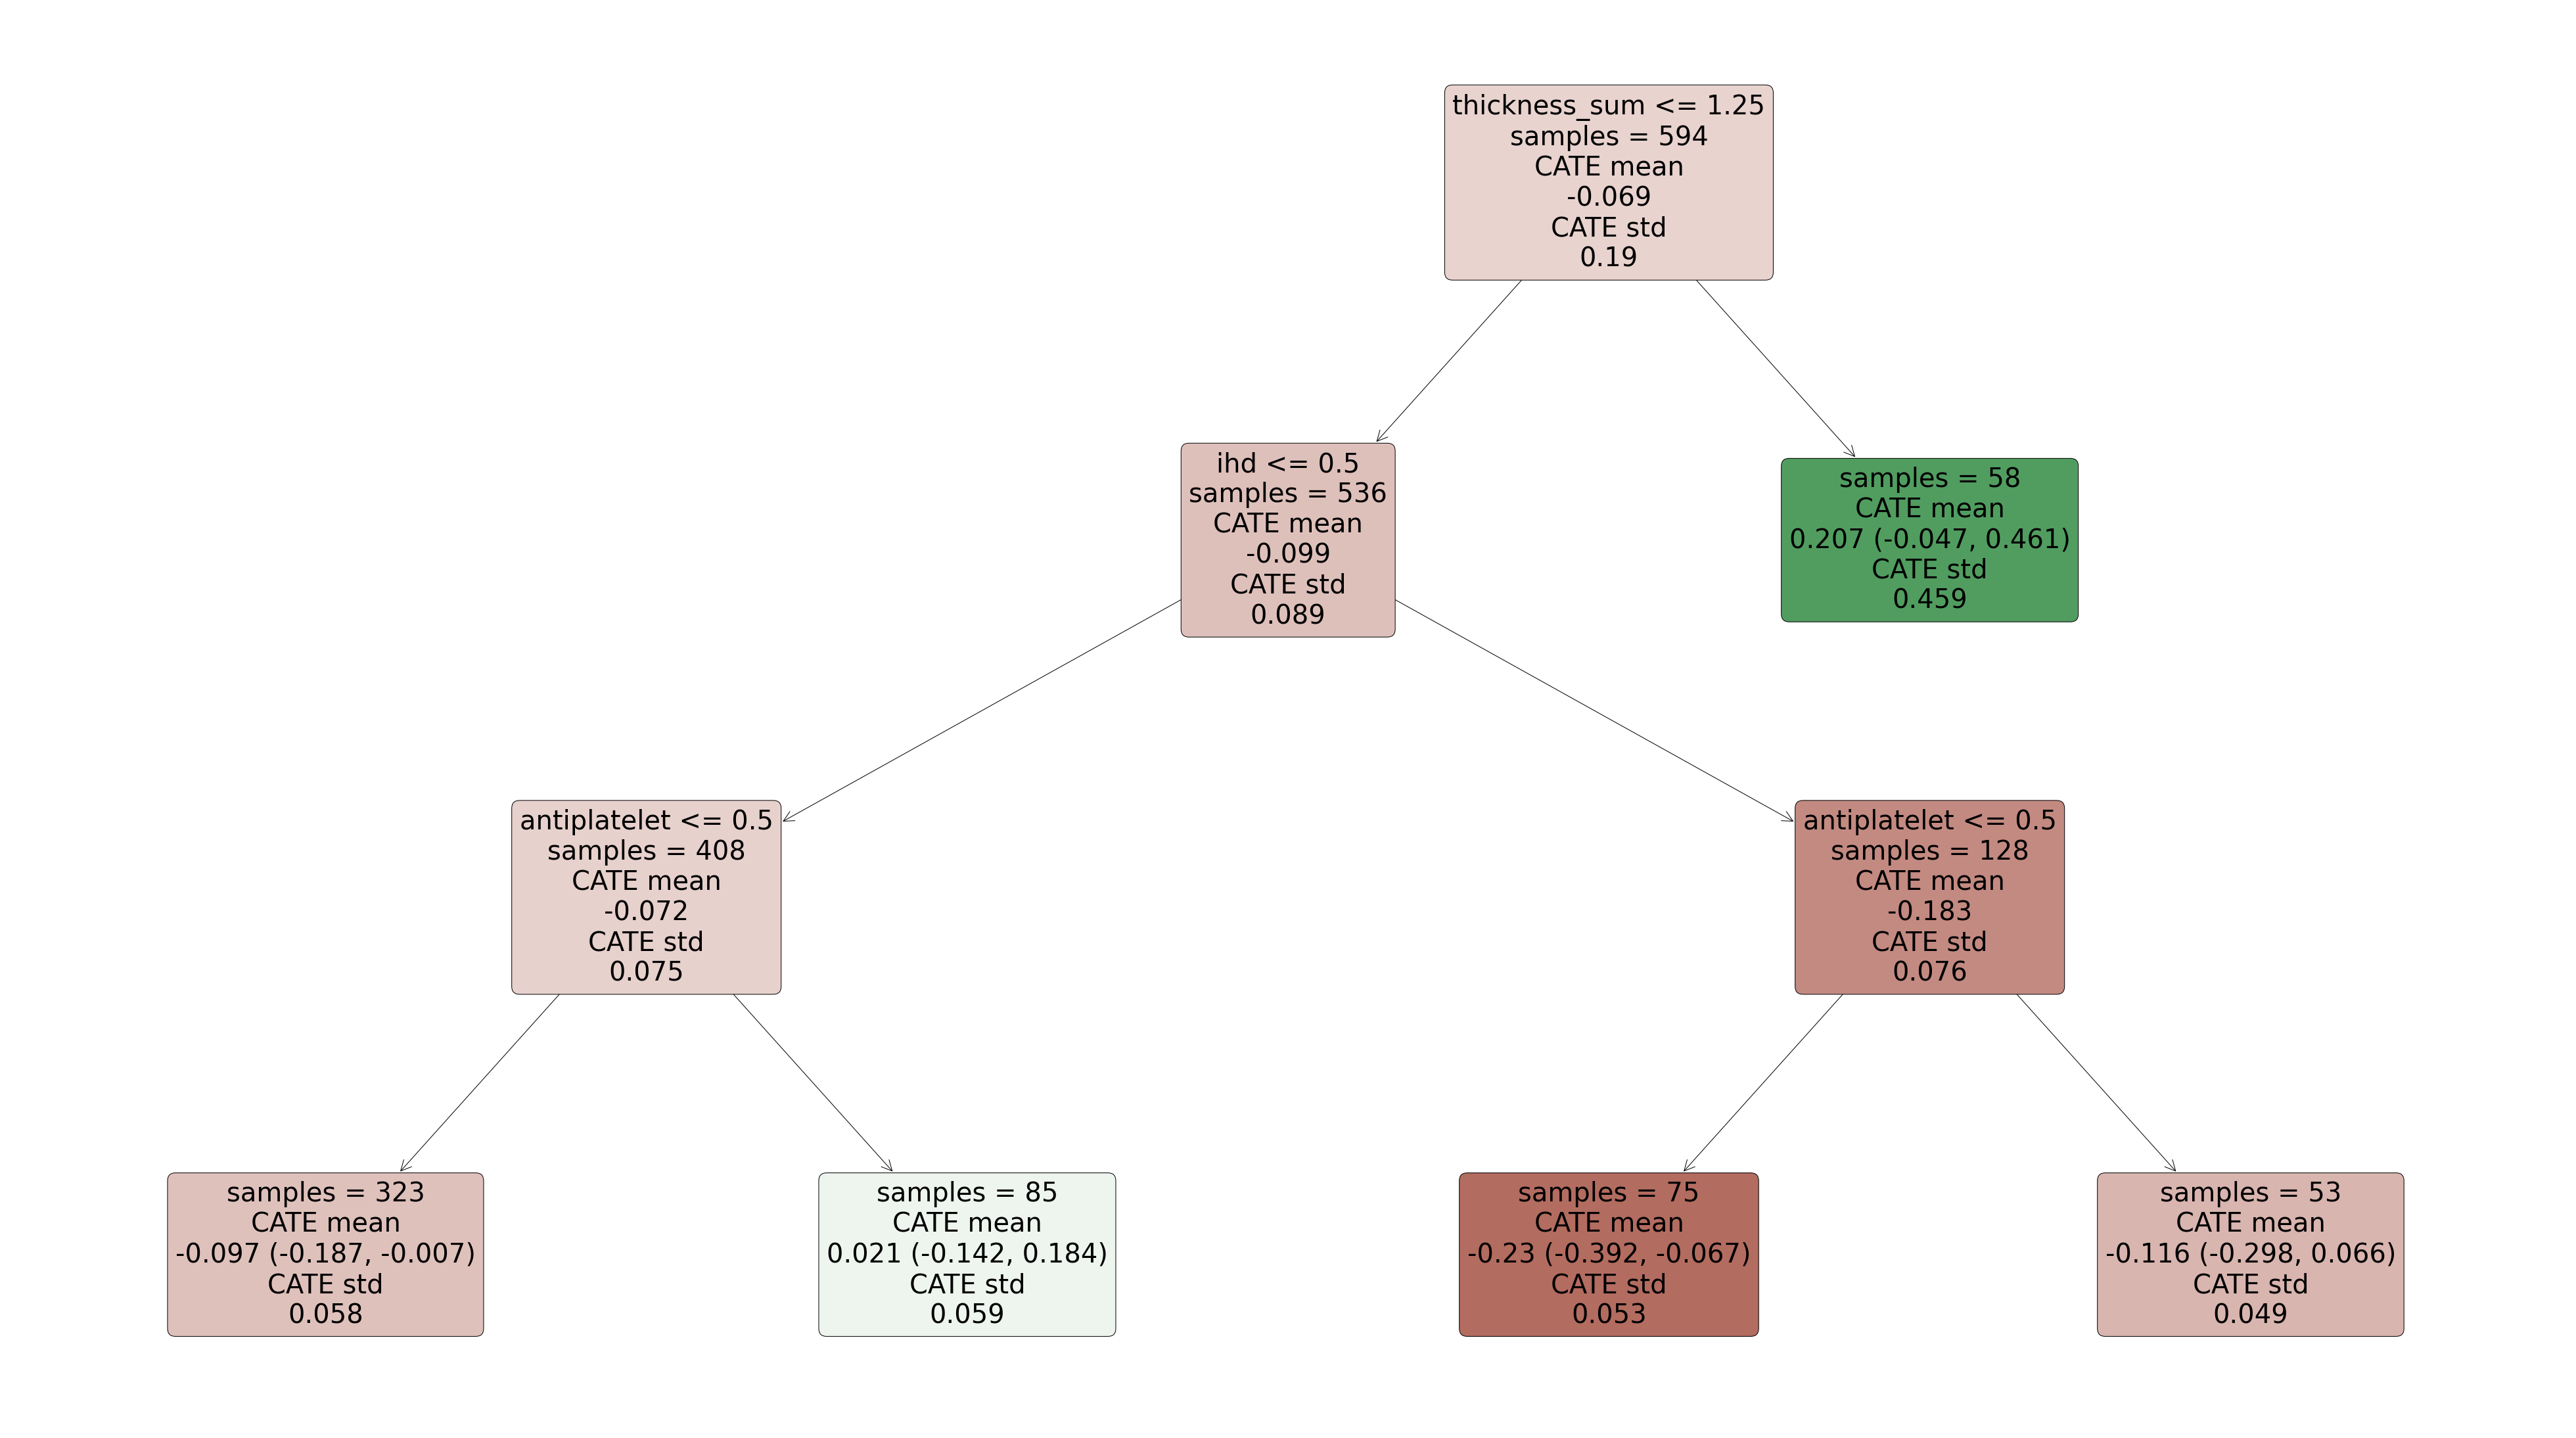

In [236]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=50)
intrp.interpret(est_dw, X)
plt.figure(figsize=(70, 40))
intrp.plot(feature_names=['burrhole_num', 'optype', 'bedrest', 'antiplatelet', 'ihd', 'metalvalve', 'age', 'membranes', 'thickness_sum'], fontsize=40)